<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_Image_Segmentation_Keras_FineTuning_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning a pre-trained Image Segmentation Keras

In this notebook, I fine-tunning a previous pre-trained model using a Image Segmentation Keras.

This notebook is a profesional deployment. All this data is **not public**.

In [1]:
from IPython.display import clear_output

## Instal Image Segmentation Keras library

From https://github.com/divamgupta/image-segmentation-keras

In [2]:
## Oficial github
# !pip install --upgrade git+https://github.com/divamgupta/image-segmentation-keras
# clear_output()

In [68]:
# My own fork
!pip install --upgrade git+https://github.com/victor-roris/image-segmentation-keras
clear_output()

## Load segmentation dataset

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
!cp /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/export..segmentation..2020.07.04.tar.gz  /content/.

In [71]:
!tar -zxvf export..segmentation..2020.07.04.tar.gz
clear_output()

Generate `train` and `val` dataset

In [72]:
import random, os

imgs_folderpath = './image'
segs_folderpath = './segmentation'

img_filenames = sorted(os.listdir(imgs_folderpath))
seg_filenames = sorted(os.listdir(segs_folderpath))

filenames = list(set(img_filenames) & set(seg_filenames))
random.shuffle(filenames)

trn_prctg = 0.7
file_count = len(filenames)
brk_idx = int(file_count*trn_prctg)

trn_img_filenames, val_img_filenames = filenames[:brk_idx], filenames[brk_idx:]

print(f"Number of train images : {len(trn_img_filenames)}")
print(f"Number of val images : {len(val_img_filenames)}")

Number of train images : 23
Number of val images : 19


In [73]:
from pathlib import Path

trn_folderpath = './trn'
trn_img_folderpath = os.path.join(trn_folderpath, "images")
trn_seg_folderpath = os.path.join(trn_folderpath, "segmentation")
val_folderpath = './val'
val_img_folderpath = os.path.join(val_folderpath, "images")
val_seg_folderpath = os.path.join(val_folderpath, "segmentation")

if os.path.isdir(trn_folderpath):
  ! rm {trn_folderpath} -R
if os.path.isdir(val_folderpath):
  ! rm {val_folderpath} -R

path = Path(trn_img_folderpath)
path.mkdir(parents=True, exist_ok=True)
path = Path(trn_seg_folderpath)
path.mkdir(parents=True, exist_ok=True)
path = Path(val_img_folderpath)
path.mkdir(parents=True, exist_ok=True)
path = Path(val_seg_folderpath)
path.mkdir(parents=True, exist_ok=True)

In [74]:
from shutil import copyfile
from tqdm import tqdm

# Copy train images-seg
for trn_img_filename in tqdm(trn_img_filenames):
  copyfile(os.path.join(imgs_folderpath, trn_img_filename),
           os.path.join(trn_img_folderpath, trn_img_filename))
  copyfile(os.path.join(segs_folderpath, trn_img_filename),
           os.path.join(trn_seg_folderpath, trn_img_filename))

# Copy val images-seg
for val_img_filename in tqdm(val_img_filenames):
  copyfile(os.path.join(imgs_folderpath, val_img_filename),
           os.path.join(val_img_folderpath, val_img_filename))
  copyfile(os.path.join(segs_folderpath, val_img_filename),
           os.path.join(val_seg_folderpath, val_img_filename)) 

100%|██████████| 964/964 [00:00<00:00, 1060.36it/s]


Label map

In [104]:
label_map_folder = "label_mapping.json"

In [105]:
import json
def load_mapping():
    try:
        with open(label_map_folder, 'r') as fp:
            return json.load(fp)
    except IOError:
        print(f'File doesn´t exist: {label_map_folder}')
        return {}

In [106]:
label_map = load_mapping()
print(f"Number of used labels : {len(label_map)}")
label_map

Number of used labels : 6


{'BACKGROUND': 0, 'figure': 5, 'list': 3, 'table': 4, 'text': 1, 'title': 2}

In [107]:
labelid_map = {}
for key in label_map:
    labelid_map[ label_map[key] ] = key
labelid_map

{0: 'BACKGROUND', 1: 'text', 2: 'title', 3: 'list', 4: 'table', 5: 'figure'}

## Load Image Segmentation Keras Model

### Download the pretrained model

In [75]:
url = "**"
user = "**"
password = "**"

In [ ]:
! wget --user {user} --password {password}  {url} -O model.tar.gz

In [77]:
!tar -zxvf model.tar.gz

README.md
pspnet_50_ADE_20K_11_config.json
pspnet_50_ADE_20K_11.2


In [78]:
!rm model.tar.gz

### Define model with the pretrained weights

In [161]:
from keras_segmentation.predict import model_from_checkpoint_path
pretrained_model = model_from_checkpoint_path("pspnet_50_ADE_20K_11")

loaded weights  pspnet_50_ADE_20K_11.2


In [80]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K
from keras_segmentation.models.model_utils import transfer_weights
from keras_segmentation.models.all_models import model_from_name

root_model = 'pspnet_50'

model = model_from_name[ root_model ](n_classes=len(label_map))
transfer_weights(pretrained_model, model)

58it [00:00, 567.25it/s]

Copying weights 


225it [00:00, 377.65it/s]

Copied weights of 120 layers and skipped 1 layers


Folder to store checkpoints

In [84]:
checkpoints_folder = "/content/checkpoints"

if os.path.isdir(checkpoints_folder):
  ! rm {checkpoints_folder} -R

path = Path(checkpoints_folder)
path.mkdir(parents=True, exist_ok=True)

## Fine-tunning pretrained model

In [85]:
train_batch_size = 4
steps_per_epoch = len(trn_img_filename) // train_batch_size

val_batch_size = 4
val_steps_per_epoch = len(val_img_filename) // val_batch_size

epochs=50
do_augment=True

checkpoint_name = "my_finetuning"

In [86]:
model.train(
    train_images = trn_img_folderpath,
    train_annotations = trn_seg_folderpath,
    checkpoints_path = os.path.join(checkpoints_folder, checkpoint_name), 
    epochs=epochs,
    # ADDED
    steps_per_epoch=steps_per_epoch,
    batch_size= train_batch_size,
    validate=True,
    val_steps_per_epoch=val_steps_per_epoch,
    val_batch_size=val_batch_size,
    val_images = val_img_folderpath, 
    val_annotations = val_seg_folderpath,
    do_augment = do_augment
    # class_weight=class_weight
)

  0%|          | 9/2247 [00:00<00:26, 84.33it/s]

Verifying training dataset


  1%|          | 9/964 [00:00<00:11, 84.42it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 964/964 [00:11<00:00, 84.39it/s]


Dataset verified! 
Epoch 1/50
5/5 [==============================] - 72s 14s/step - loss: 0.4971 - accuracy: 0.8750 - val_loss: 0.6900 - val_accuracy: 0.8935
saved  /content/checkpoints/my_finetuning.0
Epoch 2/50
5/5 [==============================] - 19s 4s/step - loss: 0.5937 - accuracy: 0.8680 - val_loss: 0.2210 - val_accuracy: 0.8908
saved  /content/checkpoints/my_finetuning.1
Epoch 3/50
5/5 [==============================] - 19s 4s/step - loss: 0.2887 - accuracy: 0.9013 - val_loss: 0.2178 - val_accuracy: 0.9318
saved  /content/checkpoints/my_finetuning.2
Epoch 4/50
5/5 [==============================] - 19s 4s/step - loss: 0.5065 - accuracy: 0.8829 - val_loss: 0.3880 - val_accuracy: 0.8943
saved  /content/checkpoints/my_finetuning.3
Epoch 5/50
5/5 [==============================] - 20s 4s/step - loss: 0.3122 - accuracy: 0.9035 - val_loss: 0.1838 - val_accuracy: 0.9344
saved  /content/checkpoints/my_finetuning.4
Epoch 6/50
5/5 [==============================] - 20s 4s/step - loss: 

In [87]:
!ls /content/checkpoints/

my_finetuning.0   my_finetuning.20  my_finetuning.32  my_finetuning.44
my_finetuning.1   my_finetuning.21  my_finetuning.33  my_finetuning.45
my_finetuning.10  my_finetuning.22  my_finetuning.34  my_finetuning.46
my_finetuning.11  my_finetuning.23  my_finetuning.35  my_finetuning.47
my_finetuning.12  my_finetuning.24  my_finetuning.36  my_finetuning.48
my_finetuning.13  my_finetuning.25  my_finetuning.37  my_finetuning.49
my_finetuning.14  my_finetuning.26  my_finetuning.38  my_finetuning.5
my_finetuning.15  my_finetuning.27  my_finetuning.39  my_finetuning.6
my_finetuning.16  my_finetuning.28  my_finetuning.4   my_finetuning.7
my_finetuning.17  my_finetuning.29  my_finetuning.40  my_finetuning.8
my_finetuning.18  my_finetuning.3   my_finetuning.41  my_finetuning.9
my_finetuning.19  my_finetuning.30  my_finetuning.42  my_finetuning_config.json
my_finetuning.2   my_finetuning.31  my_finetuning.43


In [88]:
last_output = """
72s 4s/step - loss: 0.4971 - accuracy: 0.8750 - val_loss: 0.6900 - val_accuracy: 0.8935
19s 4s/step - loss: 0.5937 - accuracy: 0.8680 - val_loss: 0.2210 - val_accuracy: 0.8908
19s 4s/step - loss: 0.2887 - accuracy: 0.9013 - val_loss: 0.2178 - val_accuracy: 0.9318
19s 4s/step - loss: 0.5065 - accuracy: 0.8829 - val_loss: 0.3880 - val_accuracy: 0.8943
20s 4s/step - loss: 0.3122 - accuracy: 0.9035 - val_loss: 0.1838 - val_accuracy: 0.9344
20s 4s/step - loss: 0.3303 - accuracy: 0.8960 - val_loss: 0.1897 - val_accuracy: 0.9433
20s 4s/step - loss: 0.2034 - accuracy: 0.9392 - val_loss: 0.1212 - val_accuracy: 0.9547
20s 4s/step - loss: 0.2289 - accuracy: 0.9000 - val_loss: 0.8345 - val_accuracy: 0.9098
20s 4s/step - loss: 0.2850 - accuracy: 0.9119 - val_loss: 0.1246 - val_accuracy: 0.9159
20s 4s/step - loss: 0.4968 - accuracy: 0.8659 - val_loss: 0.5980 - val_accuracy: 0.8927
20s 4s/step - loss: 0.5216 - accuracy: 0.8517 - val_loss: 0.4773 - val_accuracy: 0.8961
20s 4s/step - loss: 0.4781 - accuracy: 0.8766 - val_loss: 0.2112 - val_accuracy: 0.9073
20s 4s/step - loss: 0.4234 - accuracy: 0.8723 - val_loss: 0.2555 - val_accuracy: 0.9060
20s 4s/step - loss: 0.4384 - accuracy: 0.8823 - val_loss: 0.2459 - val_accuracy: 0.9309
19s 4s/step - loss: 0.2285 - accuracy: 0.9180 - val_loss: 0.1006 - val_accuracy: 0.9229
20s 4s/step - loss: 0.1642 - accuracy: 0.9462 - val_loss: 0.9980 - val_accuracy: 0.8918
20s 4s/step - loss: 0.1955 - accuracy: 0.9430 - val_loss: 0.0951 - val_accuracy: 0.9442
20s 4s/step - loss: 0.2222 - accuracy: 0.9269 - val_loss: 0.0802 - val_accuracy: 0.9057
20s 4s/step - loss: 0.1888 - accuracy: 0.9389 - val_loss: 0.5514 - val_accuracy: 0.9259
20s 4s/step - loss: 0.4135 - accuracy: 0.8842 - val_loss: 0.1418 - val_accuracy: 0.9362
20s 4s/step - loss: 0.3466 - accuracy: 0.8886 - val_loss: 0.3519 - val_accuracy: 0.9097
19s 4s/step - loss: 0.2853 - accuracy: 0.9265 - val_loss: 0.1753 - val_accuracy: 0.9307
19s 4s/step - loss: 0.4344 - accuracy: 0.8819 - val_loss: 0.0741 - val_accuracy: 0.9183
20s 4s/step - loss: 0.3333 - accuracy: 0.8885 - val_loss: 0.1693 - val_accuracy: 0.9248
19s 4s/step - loss: 0.2386 - accuracy: 0.9190 - val_loss: 0.1127 - val_accuracy: 0.9146
20s 4s/step - loss: 0.5612 - accuracy: 0.8578 - val_loss: 0.1091 - val_accuracy: 0.9070
19s 4s/step - loss: 0.3851 - accuracy: 0.8727 - val_loss: 0.1316 - val_accuracy: 0.9574
20s 4s/step - loss: 0.3275 - accuracy: 0.8917 - val_loss: 0.2884 - val_accuracy: 0.9065
19s 4s/step - loss: 0.3919 - accuracy: 0.8697 - val_loss: 0.1392 - val_accuracy: 0.9113
19s 4s/step - loss: 0.3272 - accuracy: 0.9168 - val_loss: 0.1631 - val_accuracy: 0.9651
19s 4s/step - loss: 0.2929 - accuracy: 0.9135 - val_loss: 0.1530 - val_accuracy: 0.9339
19s 4s/step - loss: 0.4530 - accuracy: 0.8765 - val_loss: 0.3032 - val_accuracy: 0.9154
20s 4s/step - loss: 0.3170 - accuracy: 0.8832 - val_loss: 0.2642 - val_accuracy: 0.9347
20s 4s/step - loss: 0.2514 - accuracy: 0.9202 - val_loss: 0.0730 - val_accuracy: 0.9354
20s 4s/step - loss: 0.3754 - accuracy: 0.8842 - val_loss: 0.1836 - val_accuracy: 0.9449
20s 4s/step - loss: 0.2552 - accuracy: 0.9110 - val_loss: 0.2312 - val_accuracy: 0.9358
20s 4s/step - loss: 0.2487 - accuracy: 0.9089 - val_loss: 0.2190 - val_accuracy: 0.9046
20s 4s/step - loss: 0.2575 - accuracy: 0.9220 - val_loss: 0.1218 - val_accuracy: 0.9472
20s 4s/step - loss: 0.1861 - accuracy: 0.9267 - val_loss: 0.0852 - val_accuracy: 0.9171
20s 4s/step - loss: 0.3791 - accuracy: 0.8842 - val_loss: 0.8220 - val_accuracy: 0.9123
20s 4s/step - loss: 0.2417 - accuracy: 0.9203 - val_loss: 0.1159 - val_accuracy: 0.9454
20s 4s/step - loss: 0.1974 - accuracy: 0.9370 - val_loss: 0.1970 - val_accuracy: 0.9294
20s 4s/step - loss: 0.1776 - accuracy: 0.9401 - val_loss: 0.0765 - val_accuracy: 0.9331
20s 4s/step - loss: 0.3031 - accuracy: 0.9260 - val_loss: 0.2422 - val_accuracy: 0.9246
20s 4s/step - loss: 0.3120 - accuracy: 0.8842 - val_loss: 0.0991 - val_accuracy: 0.9393
20s 4s/step - loss: 0.2409 - accuracy: 0.9198 - val_loss: 0.1557 - val_accuracy: 0.9228
20s 4s/step - loss: 0.1930 - accuracy: 0.9207 - val_loss: 0.1236 - val_accuracy: 0.9431
20s 4s/step - loss: 0.3221 - accuracy: 0.9098 - val_loss: 0.0957 - val_accuracy: 0.9313
20s 4s/step - loss: 0.3001 - accuracy: 0.8957 - val_loss: 0.1594 - val_accuracy: 0.9267
20s 4s/step - loss: 0.2634 - accuracy: 0.9161 - val_loss: 0.1710 - val_accuracy: 0.9619
"""

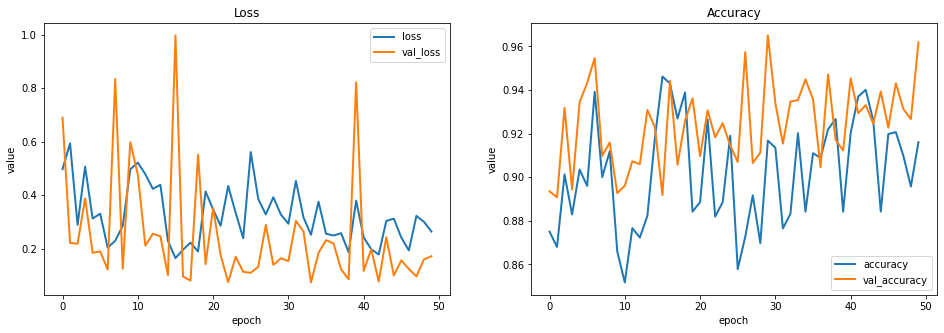

In [89]:
#output = _ #Get the output of the last cell in the notebook
output =last_output

output = str(output)

#Get the losses and accuracies showed in the output
import re
loss_accs = " ".join( re.findall(r' loss: \d+\.\d+ - accuracy: \d+\.\d+ - val_loss: \d+\.\d+ - val_accuracy: \d+\.\d+', output) )
def get_output_values(tag):
    return [float(loss.split(" ")[2]) for loss in re.findall(fr' {tag}: \d+\.\d+', loss_accs)]

losses = get_output_values("loss")
val_losses = get_output_values("val_loss")
accuracy = get_output_values("accuracy") 
val_accuracy = get_output_values("val_accuracy")

#Plot the values
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0,epochs), losses, linewidth=2.0, label="loss")
plt.plot(range(0,epochs), val_losses, linewidth=2.0, label="val_loss")
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("value");
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(range(0,epochs), accuracy, linewidth=2.0, label="accuracy")
plt.plot(range(0,epochs), val_accuracy, linewidth=2.0, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("value");
plt.legend();

## Evaluation

In [135]:
! mkdir ./checkpoints/bkp

In [146]:
! mv ./checkpoints/my_finetuning.48 ./checkpoints/bkp

In [178]:
! mv ./checkpoints/bkp/my_finetuning.49 ./checkpoints/.

In [179]:
from keras_segmentation.predict import evaluate
evaluation_result = evaluate(
    checkpoints_path= "./checkpoints/my_finetuning", 
    inp_images_dir= val_img_folderpath , 
    annotations_dir= val_seg_folderpath
)
print(evaluation_result)

loaded weights  ./checkpoints/my_finetuning.49


964it [05:19,  3.01it/s]

{'frequency_weighted_IU': 0.8822142251432205, 'mean_IU': 0.6440152250332769, 'class_wise_IU': array([0.91768929, 0.86199122, 0.47660755, 0.01557329, 0.87477834,
       0.71745167])}


In [180]:
pretrained_evaluation_result = pretrained_model.evaluate_segmentation(
    inp_images_dir= val_img_folderpath , 
    annotations_dir= val_seg_folderpath
) 
print(pretrained_evaluation_result)

964it [05:16,  3.05it/s]

{'frequency_weighted_IU': 0.8103537851612392, 'mean_IU': 0.52707090889743, 'class_wise_IU': array([0.8883954 , 0.76740669, 0.25376362, 0.03029115, 0.70759582,
       0.51497278])}


In [191]:
print(f"FNTNG - Mean IU : {evaluation_result['mean_IU']} ")
print(f"PRETR - Mean IU : {pretrained_evaluation_result['mean_IU']} ")

FNTNG - Mean IU : 0.6440152250332769 
PRETR - Mean IU : 0.52707090889743 


In [192]:
print(f"FNTNG - Frequency Weighted IU : {evaluation_result['frequency_weighted_IU']} ")
print(f"PRETR - Frequency Weighted IU : {pretrained_evaluation_result['frequency_weighted_IU']} ")

FNTNG - Frequency Weighted IU : 0.8822142251432205 
PRETR - Frequency Weighted IU : 0.8103537851612392 


In [193]:
class_wise_ui = evaluation_result['class_wise_IU']
pretrained_class_wise_ui = pretrained_evaluation_result['class_wise_IU']
for index in range(len(class_wise_ui)):
    print(f'\t - ({index}) {labelid_map[index]} :\t {class_wise_ui[index]} -- {pretrained_class_wise_ui[index]}')

	 - (0) BACKGROUND :	 0.9176892871962908 -- 0.8883953950417103
	 - (1) text :	 0.8619912173371168 -- 0.7674066947354142
	 - (2) title :	 0.4766075474114267 -- 0.2537636187496728
	 - (3) list :	 0.015573289176766507 -- 0.03029114704528612
	 - (4) table :	 0.8747783379073563 -- 0.7075958201720137
	 - (5) figure :	 0.7174516711707043 -- 0.5149727776404829


## Prediction

In [194]:
import glob
import random
from IPython.display import Image, display
import PIL
from PIL import ImageDraw
import os

In [185]:
testds_path = "./testds"
if not os.path.isdir(testds_path):
  print(" > Downloading the test dataset ")
  !wget https://www.dropbox.com/s/yow9mjgt7cs35c0/validation..doc..pages.tar.gz?dl=0  -O docpages.tar.gz
  !tar -zxvf docpages.tar.gz && ! mv validation..doc..pages {testds_path}
  !rm docpages.tar.gz
  clear_output()
  print(" > Downloaded the test dataset ")

In [237]:
rnd_img_filepath = random.choice(glob.glob(f'{testds_path}/*.png'))

val.png


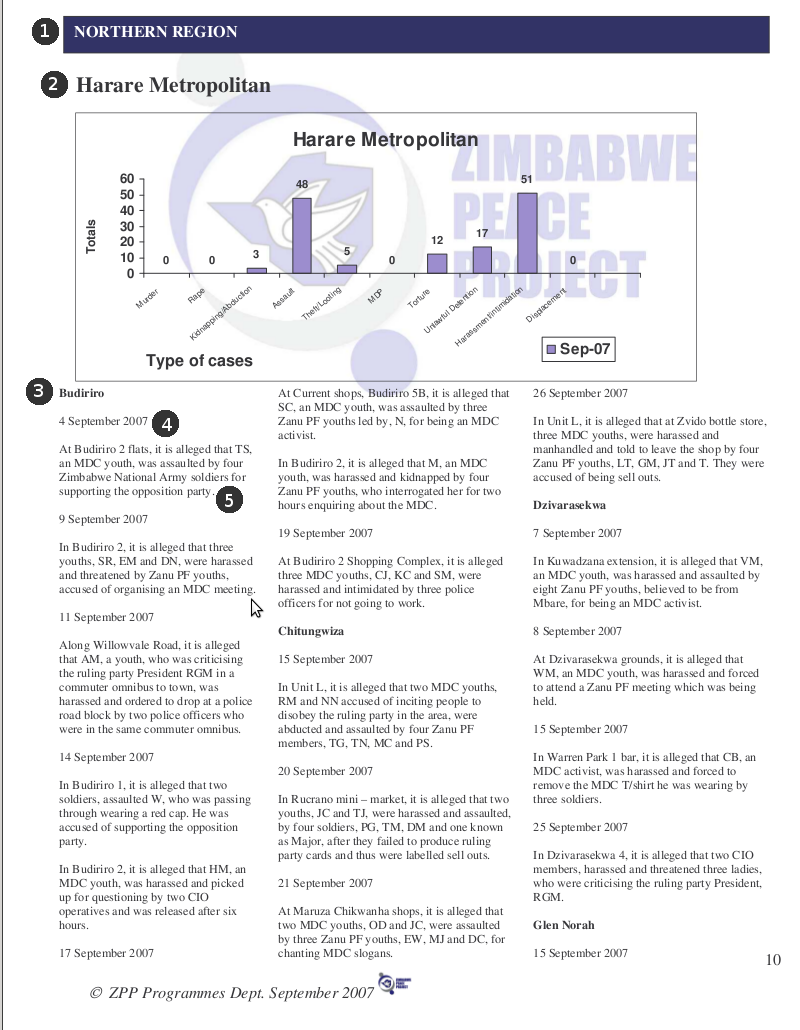

In [238]:
im = PIL.Image.open(rnd_img_filepath)

print(rnd_img_filepath)
display(im)

In [239]:
from keras_segmentation.predict import predict

out = predict( 
    checkpoints_path = "./checkpoints/my_finetuning", 
    inp = rnd_img_filepath,
    out_fname  = "./out.png"
)

pre_out = pretrained_model.predict_segmentation(
    inp=rnd_img_filepath,
    out_fname="./pre_out.png"
)

loaded weights  ./checkpoints/my_finetuning.49


Predict from fine-tuning model


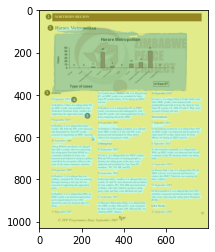

In [240]:
print(f"Predict from fine-tuning model")

inp_img = cv2.imread(rnd_img_filepath)
out_img = cv2.imread("./out.png")

from keras_segmentation.predict import overlay_seg_image
fused_img = overlay_seg_image(inp_img, out_img)

import matplotlib.pyplot as plt
plt.imshow(fused_img.astype('uint8'))

Predict from pretrained model


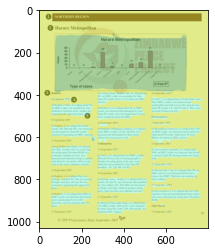

In [241]:
print(f"Predict from pretrained model")
inp_img = cv2.imread(rnd_img_filepath)
out_img = cv2.imread("./pre_out.png")

from keras_segmentation.predict import overlay_seg_image
fused_img = overlay_seg_image(inp_img, out_img)

import matplotlib.pyplot as plt
plt.imshow(fused_img.astype('uint8'))

## Export fine-tuning model

In [201]:
! cp /content/checkpoints/my_finetuning.49  /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/.
! cp /content/checkpoints/my_finetuning_config.json  /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/.